Start by importing neccesary python libraries first.

In [1]:
## python -m pip install numpy ## Version 1.14.5
## python -m pip install pandas ## Version 0.23.3
## python -m pip install sklearn ## Version 0.19.2
## python -m pip install seaborn ## Version 0.9.0

import pandas as pd
import numpy as np
import sklearn
import seaborn as sb

import visuals as vs
%matplotlib inline

C:\Users\Cillian\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Cillian\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Since the data comes in a number of different csv files, it is neccesary to first create a single data dataset. This is achieved by using the pandas `read_csv` function to read the csv into a pandas dataframe. This method also supports selective reading of columns which I have specified in the usecols parameter. Some of the columns also need to be renamed to avoid confusion.

In [2]:
## Read in results.csv, drop unneccesary columns and sort
results=pd.read_csv('data/results.csv',usecols=['raceId','driverId','grid','position'])
results=results.rename(index=str,columns={'grid':'startingGrid'})
results.sort_values(['raceId','position'],0,inplace=True)

## Read in qualifying.csv and drop unneccesary columns
qualifying=pd.read_csv('data/qualifying.csv',usecols=lambda col:col not in['number','qualifyId'])
qualifying=qualifying.rename(index=str,columns={'position':'qualifyingGrid'})

## Read in races.csv, keeping raceId and circuitId columns
races=pd.read_csv('data/races.csv',usecols=['raceId','circuitId'])

## Read in driverStandings.csv and drop unneccesary columns
driverStandings=pd.read_csv('data/driverStandings.csv',usecols=['raceId','driverId','points','position','wins'])
driverStandings=driverStandings.rename(index=str,columns={'points':'driverPoints','position':'driverPosition','wins':'driverWins'})

## Read in constructorStandings.csv and drop unneccesary columns
constructorStandings=pd.read_csv('data/constructorStandings.csv',usecols=['raceId','constructorId','points','position','wins'])
constructorStandings=constructorStandings.rename(index=str,columns={'points':'teamPoints','position':'teamPosition','wins':'teamWins'})

#drivers=pd.read_csv('drivers.csv', encoding="ISO-8859-1")
#drivers.head(10)

Next the data has to be merged into one dataset. This is done by using the `merge` method, which joins two dataframes along coommon columns.

In [3]:
## Merge the data on common columns (raceId, driverId, constructorId)
data=results.merge(qualifying,how='left')
data=data.merge(races,how='left')
data=data.merge(driverStandings,how='left')
data=data.merge(constructorStandings,how='left')

data.head()

,raceId,driverId,startingGrid,position,constructorId,qualifyingGrid,q1,q2,q3,circuitId,driverPoints,driverPosition,driverWins,teamPoints,teamPosition,teamWins
0,1,18,1,1.0,23.0,1.0,1:25.211,1:24.855,1:26.202,1,10.0,1.0,1.0,18.0,1.0,1.0
1,1,22,2,2.0,23.0,2.0,1:25.006,1:24.783,1:26.505,1,8.0,2.0,0.0,18.0,1.0,1.0
2,1,15,20,3.0,7.0,8.0,1:26.194,1:25.265,1:27.127,1,6.0,3.0,0.0,11.0,2.0,0.0
3,1,10,19,4.0,7.0,6.0,1:25.499,1:25.281,1:26.975,1,5.0,4.0,0.0,11.0,2.0,0.0
4,1,4,10,5.0,4.0,12.0,1:26.026,1:25.605,NaN,1,4.0,5.0,0.0,4.0,3.0,0.0


Once the data is loaded, it is neccesary to perform some preprocessing and cleaning. First create a new column on the data set indicated if the driver won the race or not. It also happens in this data, that some neccesary information of the winning driver is not given. In these cases, we have no option no remove these records. However the numbers are small and shouldn't affect us.

Next if we have any empty indices of non-winners, we can fill these with inforamtion associated to not winning. For example, since no constructor has an ID of zero, we associate any null constructorId to zero. This is not troublesome as we removed any records that a winner had no constructorId. Similarly, for an empty qualifyingGrid, we assign it the max qualifying grid position from the data. This is done using the `fillna` method for a dataframe.

Lastly we need to format the qualifying time cols from strings to milliseconds.

In [46]:
## Create a new column indicating if the driver won or not
data['winner']=(data['position']==1).astype(int)

##Remove data where neccesary information of the winner is not given.
for i in ['qualifyingGrid','constructorId','q1','q2','q3']:
    data=data[[not(x and y)for x,y in zip(data['winner']==1,data[i].isnull())]]
    
fillDict={'constructorId':0,
          'qualifyingGrid':max(data['qualifyingGrid']),
          'driverPoints':0,
          'driverPosition':max(data['driverPosition']),
          'driverWins':0,
          'teamPoints':0,
          'teamPosition':max(data['teamPosition']),
          'teamWins':0,
          'q1':max(data['q1'].fillna('')),
          'q2':max(data['q2'].fillna('')),
          'q3':max(data['q3'].fillna(''))
         }

data.fillna(fillDict,inplace=True)

for i in ['q1','q2','q3']:
    data[i]=data[i].str.replace('.',':')
    temp=data[i].str.split(':',expand=True)
    for j in range(3):
        temp[j]=temp[j].astype(int)
    
    temp[0]=temp[0]*60000
    temp[1]=temp[1]*1000
    data[i]=temp[0]+temp[1]+temp[2]

#data=data.astype({'position':int,'points':int,'milliseconds':int,
#                    'fastestLap':int,'fastestLapTime':int,'qualifyId':int,'qualifyingGrid':int})    

data.head()

,raceId,driverId,startingGrid,position,constructorId,qualifyingGrid,q1,q2,q3,circuitId,driverPoints,driverPosition,driverWins,teamPoints,teamPosition,teamWins,winner
0,1,18,1,1.0,23.0,1.0,85211,84855,86202,1,10.0,1.0,1.0,18.0,1.0,1.0,1
1,1,22,2,2.0,23.0,2.0,85006,84783,86505,1,8.0,2.0,0.0,18.0,1.0,1.0,0
2,1,15,20,3.0,7.0,8.0,86194,85265,87127,1,6.0,3.0,0.0,11.0,2.0,0.0,0
3,1,10,19,4.0,7.0,6.0,85499,85281,86975,1,5.0,4.0,0.0,11.0,2.0,0.0,0
4,1,4,10,5.0,4.0,12.0,86026,85605,129776,1,4.0,5.0,0.0,4.0,3.0,0.0,0


In [47]:
data.describe()

,raceId,driverId,startingGrid,position,constructorId,qualifyingGrid,q1,q2,q3,circuitId,driverPoints,driverPosition,driverWins,teamPoints,teamPosition,teamWins,winner
count,23021.000000,23021.000000,23021.000000,12471.000000,23021.000000,23021.000000,2.302100e+04,23021.000000,23021.000000,23021.000000,23021.000000,23021.000000,23021.000000,23021.000000,23021.000000,23021.000000,23021.000000
mean,488.106251,227.316711,11.542722,8.193409,11.304591,22.737631,1.336330e+05,125690.941705,125956.369489,21.682203,13.124247,17.319665,0.253117,18.498501,11.475696,0.257461,0.009687
std,271.180739,233.037665,7.289625,4.574199,38.835073,8.458940,3.117001e+04,16321.810748,12372.373062,15.812656,32.518108,16.939565,0.917635,62.737181,4.120079,1.260560,0.097946
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,6.506400e+04,64316.000000,64251.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,274.000000,55.000000,5.000000,4.000000,0.000000,18.000000,9.870300e+04,132470.000000,129776.000000,9.000000,0.000000,7.000000,0.000000,0.000000,9.000000,0.000000,0.000000
50%,478.000000,154.000000,11.000000,8.000000,0.000000,28.000000,1.538850e+05,132470.000000,129776.000000,18.000000,2.000000,14.000000,0.000000,0.000000,14.000000,0.000000,0.000000
75%,720.000000,314.000000,17.000000,11.000000,4.000000,28.000000,1.538850e+05,132470.000000,129776.000000,31.000000,11.000000,21.000000,0.000000,1.000000,14.000000,0.000000,0.000000
max,988.000000,843.000000,34.000000,33.000000,210.000000,28.000000,1.002640e+06,132470.000000,129776.000000,73.000000,397.000000,105.000000,13.000000,765.000000,14.000000,19.000000,1.000000


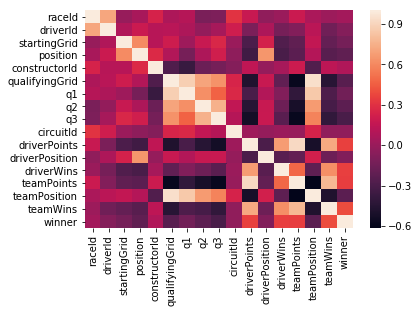

In [48]:
corr = data.corr()
sb.heatmap(corr)

The correlation graph above has some surprising features. We can see a highly correlated square in thr centre of the grid corresponding to `qualifyingGrid`,`q1`,`q2` and `q3`. This is not surprising since a faster qualifying time means a higher grid position. These four attributes are also highly correlated to `teamPosititon`, which again isn't too surprising since if a team is performing well, it is likely they have better driver and cars which would lead to better times on track. 

However, it is interesting to note that these attributes are not strongly correlated to the feature we are interested in, `winner`. From the graph, it appears that `winner` is strongly correlated to `teamWins`,`teamPoints`,`driverWins` and `driverPoints`. These attributes are in themselves not surprising, however worth noting that other seemingly important factors (e.g. `driverID`,`startingGrid` and `circuitId`) are not strongly correlated.

This would lead us to believe that a driver and a team performing well stand more of a chance of winning any given race, rather than a particular driver starting from the front  of the grid on his favourite circuit.

Next, it is worthwhile producing a naive model. Each F1 race has approximately 20 participants. Since each race can only have one winner, this gives a 1 in 20 or 5% chance of any driver winning. Conversely, it gives a 19 in 20 or 95% chance of not winning. So, in this case if were to naively predict that a driver was to lose, we would be correct approximately 95% of the time.

In [49]:
## No true or false postives as we are assuming no winners
TP=0
FP=0

## TN where the winner is correctly predicted as 0
TN=sum(data['winner']==0)
FN=len(data)-TN

naiveAccuracy = (TP+TN)/len(data)
#naiveRecall = TP/(TP+FN)
naiveRecall=1  ## as TP=0
#naivePrecision = TP/(TP+FP)
naivePrecision=1 ## as FP=0

naiveFScore = (1+(0.5**2))*(naivePrecision*naiveRecall)/(0.5**2*naivePrecision+naiveRecall)

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naiveAccuracy,naiveFScore))

Naive Predictor: [Accuracy score: 0.9903, F-score: 1.0000]


As it turns out, this is a very accurate model. We will have our work cut out for us here to produce a better one.

Now that we have a naive model, we move on with producing a more sophisticated one. We split the data into our outcome and the features that contributed, and split both of these into our training and testing sets using `train_test_split`.

In [50]:
outcome=data['winner']

## Features that are likely to have contributed to the outcome
features=data.drop(['position','winner'],1)

In [51]:
from sklearn.model_selection import train_test_split

X=features
y=np.array(outcome)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 18416 samples.
Testing set has 4605 samples.


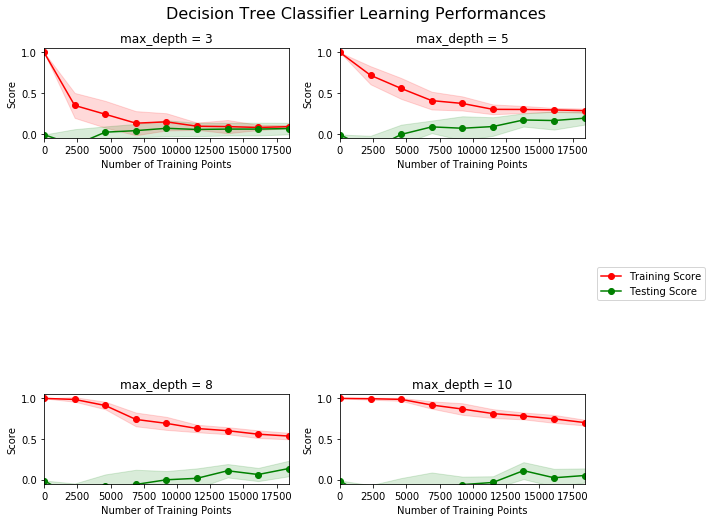

In [30]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features,outcome)

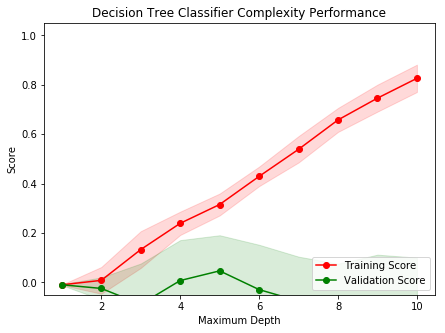

In [31]:
vs.ModelComplexity(X_train, y_train)

The below code defines a function to evaluate the r2 score on a certain model between the actual outcomes and the predicted outcomes. And we then run a grid search over the max depth parameter to find the optimal model.

In [32]:
from sklearn.metrics import r2_score 

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    score =  r2_score(y_true,y_predict)
    
    return score

In [33]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
    
    regressor = DecisionTreeClassifier()

    params = {'max_depth':[371,372,373,374,375,376,377,378,379,380]}
 
    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(regressor,param_grid=params, scoring=scoring_fnc, cv=cv_sets)
    
    grid = grid.fit(X, y)
    
    return grid.best_estimator_

In [52]:
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 374 for the optimal model.


Now that we have a trained model, we can use it on our features dataset to see how accurate it is.

In [53]:
predictions=reg.predict(features)
res=np.array(outcome)

## Where the model correctly corrects the winner
TP=sum([x and y for x,y in zip(predictions==1,res==1)])
## Where the model incorrectly predicts the winner
FP=sum([x and y for x,y in zip(predictions==1,res!=1)])
## Where the model correctly predicts a non-winner
TN=sum([x and y for x,y in zip(predictions!=1,res!=1)])
## Where the model incorrectly predicts a non-winner
FN=sum([x and y for x,y in zip(predictions!=1,res==1)])

DTCAccuracy = (TP+TN)/len(data)
DTCRecall = TP/(TP+FN)
DTCPrecision = TP/(TP+FP)

DTCFScore = (1+(0.5**2))*(DTCPrecision*DTCRecall)/(0.5**2*DTCPrecision+DTCRecall)

print("The r2 score for the Decision Tree Classifier is {:.4f}.".format(performance_metric(outcome,predictions)))
print("Decision Tree Classifier: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(DTCAccuracy,DTCFScore))

The r2 score for the Decision Tree Classifier is 0.8053.
Decision Tree Classifier: [Accuracy score: 0.9981, F-score: 0.9026]


This is quite an accurate model, more accurate than our naive model. This is good, but our F score has decreased. Perhaps this data is complex and while works for the Decision Tree Classifier, it might be suited to a more advanced model.

However, before trying another model, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution, however normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below. We use sklearn.preprocessing.MinMaxScaler for this.

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

features=pd.DataFrame(features)
features[features.columns]=scaler.fit_transform(features)

features.head()

,raceId,driverId,startingGrid,constructorId,qualifyingGrid,q1,q2,q3,circuitId,driverPoints,driverPosition,driverWins,teamPoints,teamPosition,teamWins
0,0.0,0.020190,0.029412,0.109524,0.000000,0.021488,0.301362,0.335002,0.0,0.025189,0.000000,0.076923,0.023529,0.000000,0.052632
1,0.0,0.024941,0.058824,0.109524,0.037037,0.021270,0.300305,0.339626,0.0,0.020151,0.009615,0.000000,0.023529,0.000000,0.052632
2,0.0,0.016627,0.588235,0.033333,0.259259,0.022537,0.307377,0.349119,0.0,0.015113,0.019231,0.000000,0.014379,0.076923,0.000000
3,0.0,0.010689,0.558824,0.033333,0.185185,0.021796,0.307612,0.346799,0.0,0.012594,0.028846,0.000000,0.014379,0.076923,0.000000
4,0.0,0.003563,0.294118,0.019048,0.407407,0.022358,0.312366,1.000000,0.0,0.010076,0.038462,0.000000,0.005229,0.153846,0.000000


To properly evaluate the performance of the model we choose, it is important to create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. We implement this is in the code block below.

In [55]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5,average=None)
        
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5,average=None)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

We now run a sample of models from `sklearn` through our training and testing pipline and graph the reuslts.

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

clf_A = GradientBoostingClassifier(random_state=5)
clf_B = SVC(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)
clf_D = GaussianNB()
clf_E = LogisticRegression(random_state=0)

samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

results = {}
for clf in [clf_A, clf_B, clf_C,clf_D,clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

GradientBoostingClassifier trained on 184 samples.
GradientBoostingClassifier trained on 1841 samples.
GradientBoostingClassifier trained on 18416 samples.


C:\Users\Cillian\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 184 samples.
SVC trained on 1841 samples.
SVC trained on 18416 samples.
AdaBoostClassifier trained on 184 samples.
AdaBoostClassifier trained on 1841 samples.
AdaBoostClassifier trained on 18416 samples.
GaussianNB trained on 184 samples.
GaussianNB trained on 1841 samples.
GaussianNB trained on 18416 samples.
LogisticRegression trained on 184 samples.


C:\Users\Cillian\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression trained on 1841 samples.
LogisticRegression trained on 18416 samples.


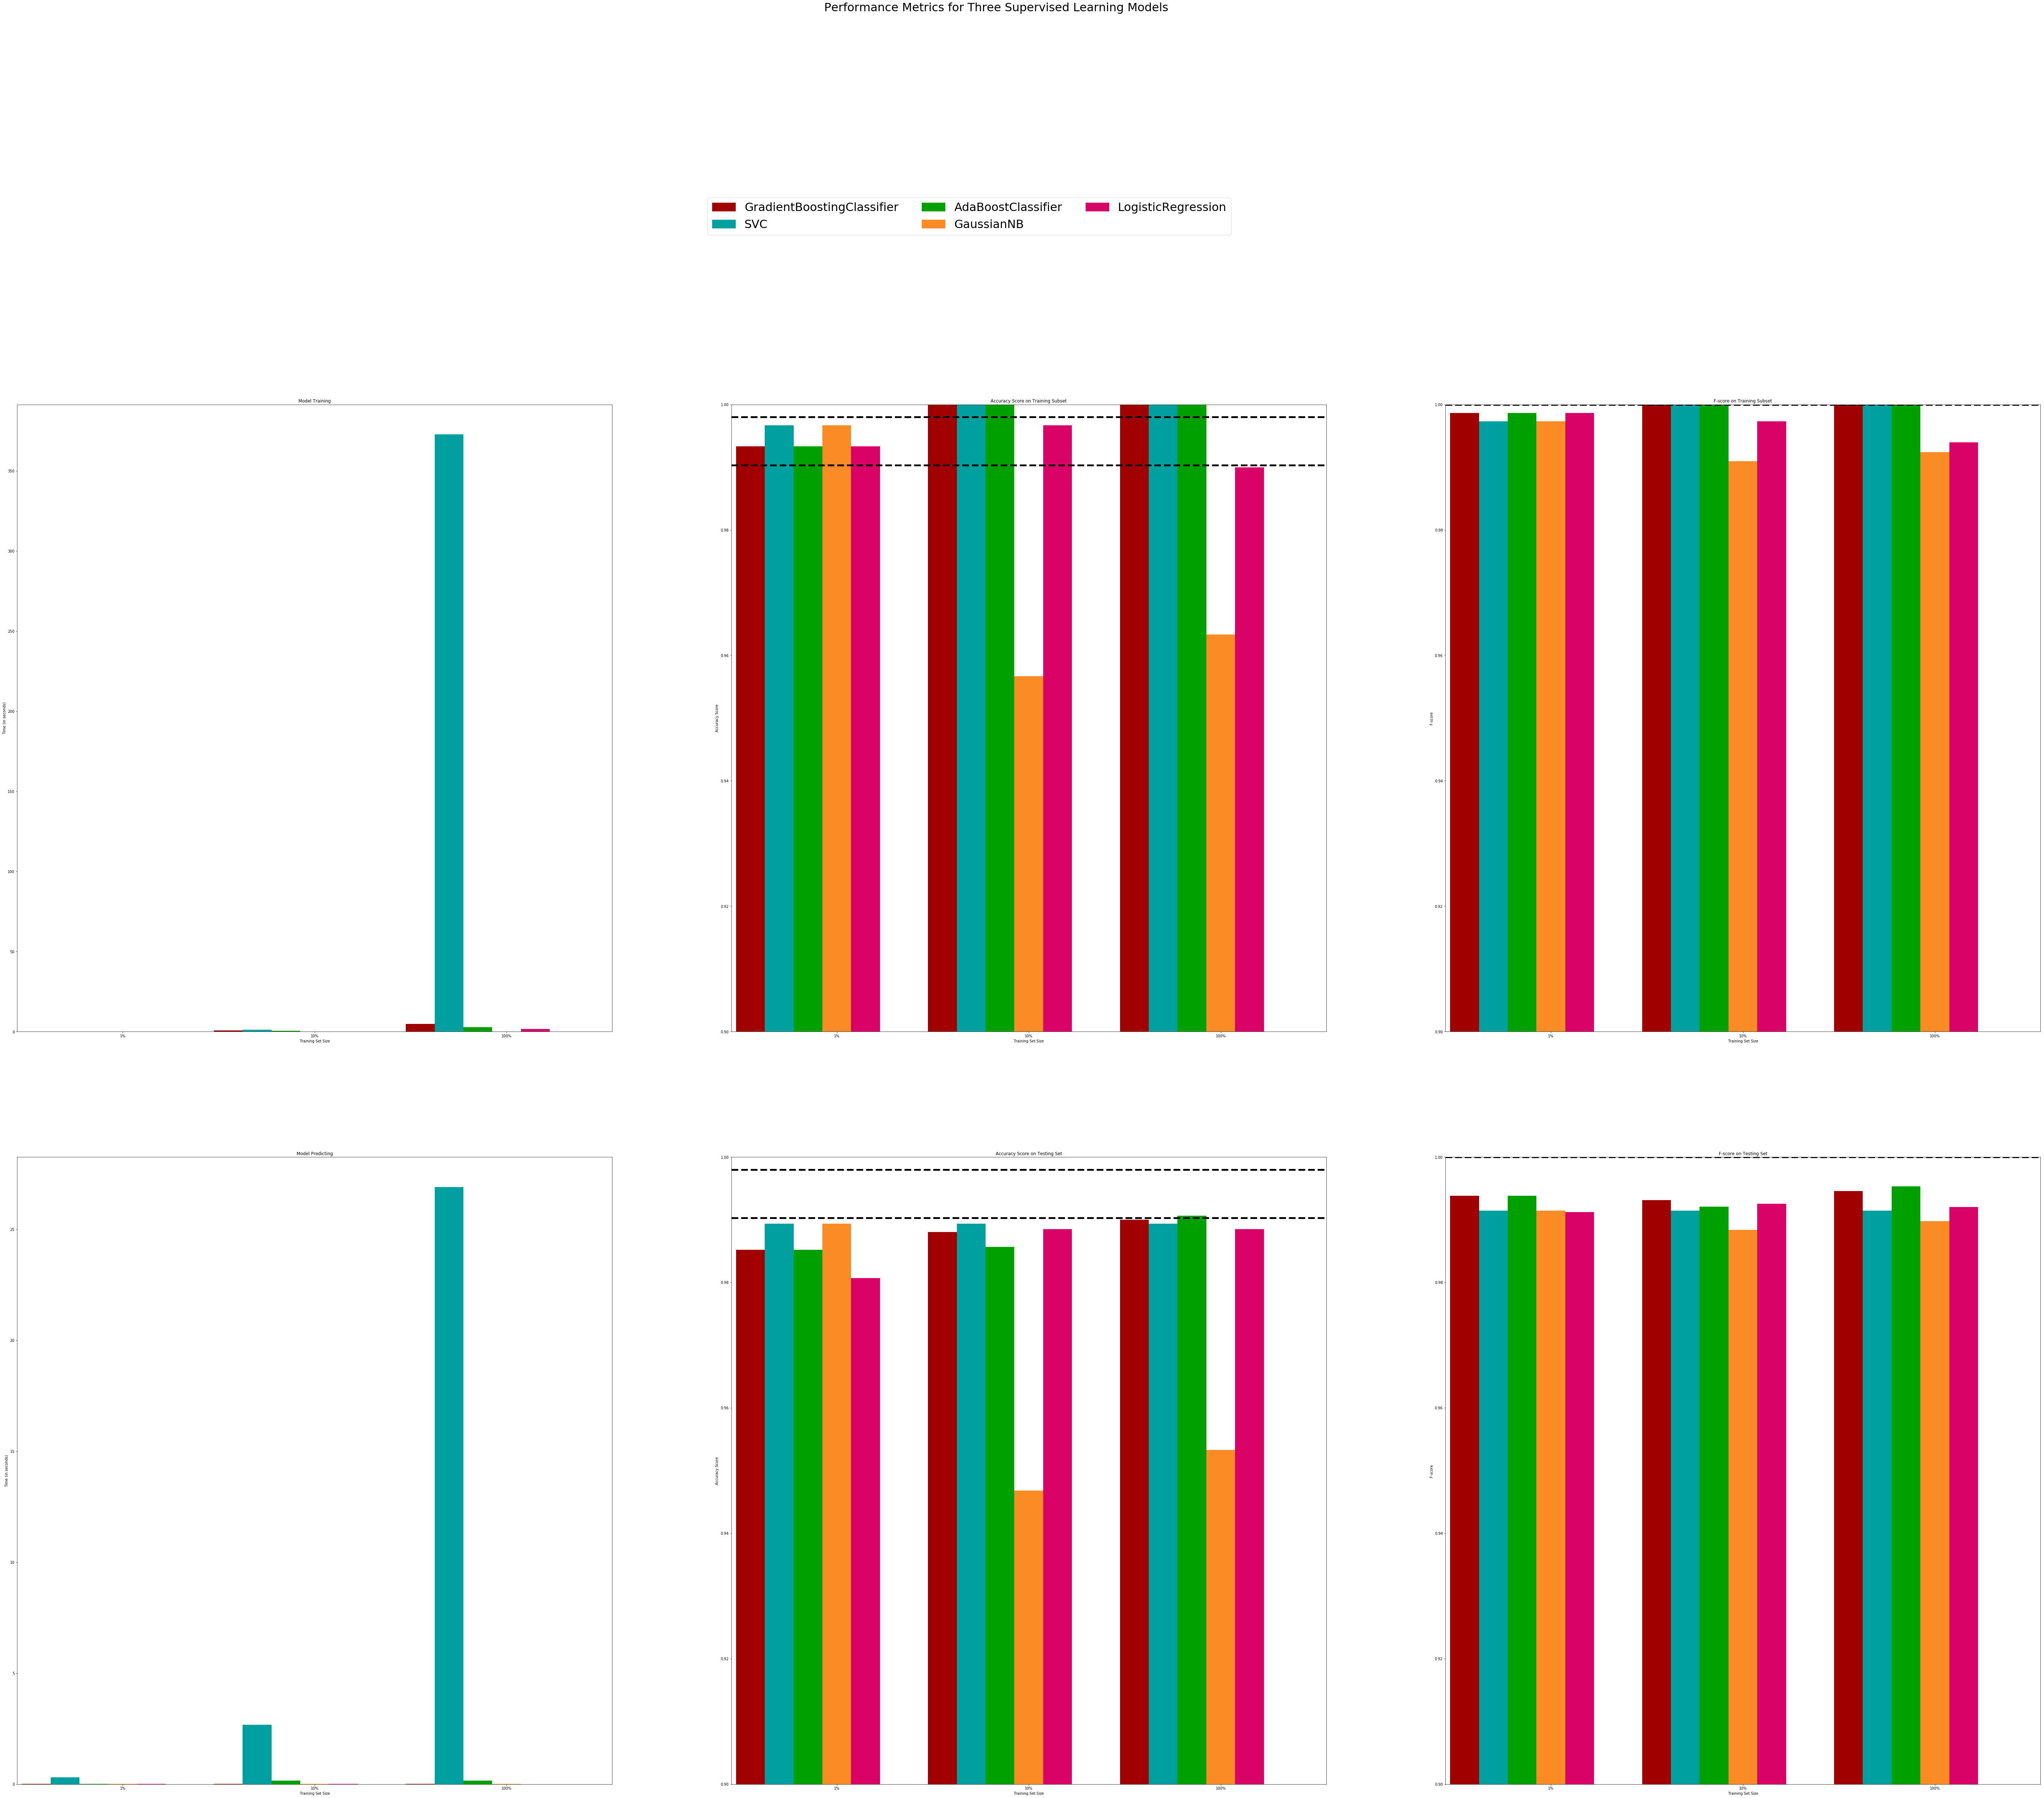

In [39]:
## Run metrics visualization for the three supervised learning models chosen vs Decision Tree Classifier and Naive Model
## Note y-axis runs from 0.9 to 1 to show the differences in accuracy clearer

vs.evaluate(results,DTCAccuracy,DTCFScore,naiveAccuracy,naiveFScore)

As we can see from the graphs above all models are giving very high accuracies. All that remains is to choose a model and then use `GridSearchCV` to fine-tune the parameters. I choose to use the `AdaBoostClassifier` since it has a very high accuracy level and has also been used to analyse race data before at http://www-math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf. Adaboost has the advantage that is a fast algorithm, by mainly focusing on the incorrectly classified points on each iteration and assigning them a higher weight. The disadvantages of the AdaBoostClassifier is that it is sensitive to complex data and outliers in the data. This is also a good model to use on our dataset since we have a large dataset but it is not too complex. We will be able to carry out multiple training iterations on the data to achieve more accuracy overall.

In [56]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(random_state=0)

parameters={'n_estimators':[2,5,8,10,12],'learning_rate':[1.0],'random_state':[0,1,2,3,4,5]}

scorer =  make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.9907
F-score on testing data: 0.5622

Optimized Model
------
Final accuracy score on the testing data: 0.9913
Final F-score on the testing data: 0.5929


As seen above, our new model has a very high level of accuracy even when unoptimised. However it's accuracy falls between that of the naive predictor and that of the Decision Tree Classifier. Recall:

In [57]:
print("Decision Tree Classifier: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(DTCAccuracy,DTCFScore))
print("Naive Predictor:          [Accuracy score: {:.4f}, F-score: {:.4f}]".format(naiveAccuracy,naiveFScore))

Decision Tree Classifier: [Accuracy score: 0.9981, F-score: 0.9026]
Naive Predictor:          [Accuracy score: 0.9903, F-score: 1.0000]


The F score of the AdaBoostClassifier also  lies below that of both previous models.

It is also interesting to see what the more important features of the dataset which contributed to the outcome were. For this, we can use `feature_importances_` and we draw them on a plot, along with the cumulative feature weight.

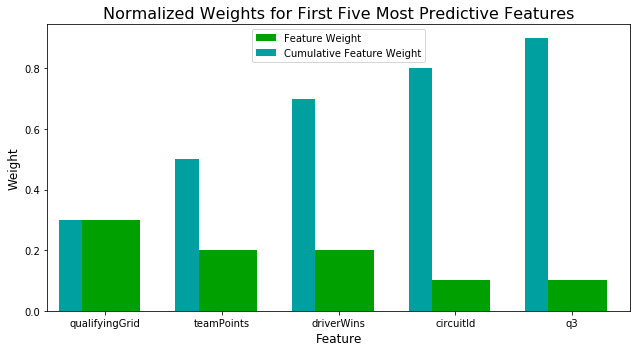

In [58]:
model=AdaBoostClassifier(random_state=0,n_estimators=10,learning_rate=1.0).fit(X_train, y_train)

importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)

The graph above tells us that the top five most important features were `qualifyingGrid`,`driverWins`,`teamPoints`,`circuitId` and `q3`. When compared to the correlation matrix above, this yields some surprising results. For example, qualifingGrid, circuitId and q3 were not strongly correlated to the outcome of the race but yet, qualifying Grid is the most important feature of the model. (In a sense, this is not surprised since the leader at the beginning of the race has the biggest adavantage from the start.) We also see driverWins and teamPoints appear as the 2nd and 3rd most important feature and this agrees with the correlation matrix. It is also interesting to note that q3 appears rather than q2 or q1. This is because all drivers compete in q1 and register a time. Then the slowest 5 drivers are dropped and the 15 remaining register a new time. Again, the remaining 10  register a time for q3 and this determines the qualifying grid position. Hence, it makes sense that drivers with a lower q3 time (compared to no q3 time) are likely to be better drivers and have a better chance of winning the race outright. It is alos interesting that qualifying grid appears rather than starting grid. (The driver may have incurred a penalty for some incident, however the model takes care of this.)

The graph above indicates that a driver with a high qualifying grid position, with a lot of wins under his belt, driving for a team doing well and on a circuit he likes, is most likely to win a given race.

It is also interesting to see if we can create a model using only these five features, which still gives an accurate result but saves us some computation time by ignoring possibly negligible features. We use `clone` for this purpose.

In [59]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.9913
F-score on testing data: 0.5929

Final Model trained on reduced data
------
Accuracy on testing data: 0.9913
F-score on testing data: 0.5929


So it seems that we can create a slimmed down model using only these five features which is as accurate as a model trained on the whole dataset. However, the f-score decreases by one part in a hundred which is a small price to pay for a computationally less intense model.